In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
from PIL import Image
import numpy as np

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [2]:
# Hyperparameters
batch_size = 256 #was 32
epochs = 15
learning_rate = 0.001
image_size = (224, 224)

In [3]:
# Paths
train_image_dir = "../data/images/train"
train_label_file = "../data/attribute_matrix_train.txt"
test_image_dir = "../data/images/test"
test_label_file = "../data/attribute_matrix_test.txt"


# Transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
def process_group_labels(group_labels):
    found_one = False
    processed_labels = []
    
    for idx, value in enumerate(group_labels):
        if value == 1 and not found_one:
            processed_labels.append(1)
            found_one = True
        else:
            processed_labels.append(0)
    
    # Wenn keine 1 gefunden wurde, setze das erste Element auf 1
    if not found_one:
        processed_labels[0] = 1
    
    return processed_labels


In [5]:
#DEFINE DATASET
class GroupedImageDataset(Dataset):
    def __init__(self, image_dir, label_file, attribute_groups, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True))
        raw_labels = np.loadtxt(label_file, dtype=int)
        self.attribute_groups = attribute_groups
        self.transform = transform
        #prepare grouped labels
        self.labels = [
             {group: torch.tensor(process_group_labels([label[idx] for idx in indices]), dtype=torch.long).argmax()
              for group, indices in attribute_groups.items()}
             for label in raw_labels
        ]

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

In [6]:
#DEFINE THE MODEL
class ResNetGroupedMultiClass(nn.Module):
    def __init__(self, attribute_groups):
        super(ResNetGroupedMultiClass, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        self.dropout = nn.Dropout(0.5)
        self.group_classifiers = nn.ModuleDict({
            group_name: nn.Linear(in_features, len(indices))
            for group_name, indices in attribute_groups.items()
        })

    def forward(self, x):
        features = self.resnet(x)
        features = self.dropout(features)
        outputs = {
            group_name: classifier(features)
            for group_name, classifier in self.group_classifiers.items()
        }
        return outputs

In [7]:
# Attribute Groups
attribute_groups = {
    "has_bill_shape": list(range(0, 9)),
    "has_wing_color": list(range(9, 24)),
    "has_upperparts_color": list(range(24, 39)),
    "has_underparts_color": list(range(39, 54)),
    "has_breast_pattern": list(range(54, 58)),
    "has_back_color": list(range(58, 73)),
    "has_tail_shape": list(range(73, 79)),
    "has_upper_tail_color": list(range(79, 94)),
    "has_head_pattern": list(range(94, 105)),
    "has_breast_color": list(range(105, 120)),
    "has_throat_color": list(range(120, 135)),
    "has_eye_color": list(range(135, 149)),
    "has_bill_length": list(range(149, 152)),
    "has_forehead_color": list(range(152, 167)),
    "has_under_tail_color": list(range(167, 182)),
    "has_nape_color": list(range(182, 197)),
    "has_belly_color": list(range(197, 212)),
    "has_wing_shape": list(range(212, 217)),
    "has_size": list(range(217, 222)),
    "has_shape": list(range(222, 236)),
    "has_back_pattern": list(range(236, 240)),
    "has_tail_pattern": list(range(240, 244)),
    "has_belly_pattern": list(range(244, 248)),
    "has_primary_color": list(range(248, 263)),
    "has_leg_color": list(range(263, 278)),
    "has_bill_color": list(range(278, 293)),
    "has_crown_color": list(range(293, 308)),
    "has_wing_pattern": list(range(308, 312)),
}

In [8]:
def class_count(group, class_idx, labels):
    count = 0
    for label in labels:
        if label[group] == class_idx:
            
            count += 1
    return count

In [9]:
train_dataset = GroupedImageDataset(train_image_dir, train_label_file, attribute_groups, transform)
test_dataset = GroupedImageDataset(test_image_dir, test_label_file, attribute_groups, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:

# Berechnung der Häufigkeiten und Gewichte
group_class_frequencies = {
    group: torch.tensor(
        [class_count(group, class_idx, train_dataset.labels) for class_idx in range(len(indices))],
        dtype=torch.float32
    )
    for group, indices in attribute_groups.items()
}
group_class_frequencies

{'has_bill_shape': tensor([ 306.,  805.,   93.,  140.,  378.,  245., 2281., 1614.,  132.]),
 'has_wing_color': tensor([ 772., 1602.,   78.,   13.,   49., 1454.,  270.,  127.,   44.,   12.,
           67., 1194.,  137.,   44.,  131.]),
 'has_upperparts_color': tensor([1105., 1457.,  111.,   16.,   51., 1384.,  268.,  120.,   38.,   11.,
           72., 1022.,  164.,   61.,  114.]),
 'has_underparts_color': tensor([ 758.,  613.,   78.,   10.,   72., 1011.,  744.,   76.,   31.,   25.,
          120.,  658., 1302.,  134.,  362.]),
 'has_breast_pattern': tensor([3852.,  370.,  699., 1073.]),
 'has_back_color': tensor([1550., 1207.,   78.,   17.,   38., 1212.,  238.,  120.,   37.,   18.,
           42.,  972.,  213.,   70.,  182.]),
 'has_tail_shape': tensor([1543.,  649., 1792.,  478., 1042.,  490.]),
 'has_upper_tail_color': tensor([2207.,  888.,   50.,   11.,   36.,  966.,  158.,   94.,   30.,   30.,
           49., 1014.,  230.,   72.,  159.]),
 'has_head_pattern': tensor([ 461.,  551., 

In [11]:
#TODO - adjust weights, because it does not work properly
# Berechnung der Häufigkeiten und Gewichte
group_class_frequencies = {
    group: torch.tensor(
        [class_count(group, class_idx, train_dataset.labels) for class_idx in range(len(indices))],
        dtype=torch.float32
    )
    for group, indices in attribute_groups.items()
}

total_samples ={
    group:group_class_frequencies[group].sum()
    for group in attribute_groups.keys()
}

num_classes = {
    group:len(group_class_frequencies[group])
    for group in attribute_groups.keys()
}

group_weights = {
    group: total_samples[group] / (num_classes[group] * group_class_frequencies[group])
    for group in attribute_groups.keys()
}

print(f"Class weights {group}: {group_weights[group]}" for group in attribute_groups.keys()) 


<generator object <genexpr> at 0x7f3343325f20>


In [12]:
# Model, Loss, and Optimizer
model = ResNetGroupedMultiClass(attribute_groups).to(device)
criterion = {
    group: nn.CrossEntropyLoss(weight=group_weights[group].to(device))
    for group in attribute_groups.keys()
}
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [13]:
from sklearn.metrics import balanced_accuracy_score
def train_grouped_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_predictions = {group: 0 for group in attribute_groups.keys()}
        total_samples = {group: 0 for group in attribute_groups.keys()}

        all_true_labels = {group: [] for group in attribute_groups.keys()}
        all_predictions = {group: [] for group in attribute_groups.keys()}

        combined_true_labels = []
        combined_predictions = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}

            optimizer.zero_grad()
            outputs = model(images)

            # Calculate loss
            loss = sum(criterion[group](outputs[group], labels[group]) for group in outputs) / len(outputs)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Collect predictions and true labels for accuracy
            for group in outputs:
                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)

                # Append labels and predictions for balanced accuracy
                all_true_labels[group].extend(labels[group].cpu().numpy())
                all_predictions[group].extend(preds.cpu().numpy())

                # Combine for overall balanced accuracy
                combined_true_labels.extend(labels[group].cpu().numpy())
                combined_predictions.extend(preds.cpu().numpy())

        # Display accuracy for each group
        for group in correct_predictions:
            acc = correct_predictions[group] / total_samples[group]
            print(f"Accuracy for group {group}: {acc:.4f}")

        # Display balanced accuracy for each group
        for group in all_true_labels:
            bal_acc = balanced_accuracy_score(all_true_labels[group], all_predictions[group])
            print(f"Balanced Accuracy for group {group}: {bal_acc:.4f}")

        # Calculate overall balanced accuracy
        overall_bal_acc = balanced_accuracy_score(combined_true_labels, combined_predictions)
        print(f"Overall Balanced Accuracy: {overall_bal_acc:.4f}")

        torch.save(model.state_dict(), '../models/grouped_attribute_predictor_weighted.pth')
        torch.save(optimizer.state_dict(), '../models/grouped_attribute_predictor_optimizer.pth')


In [14]:
from sklearn.metrics import balanced_accuracy_score

# Evaluation Function
def evaluate_grouped_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    correct_predictions = {group: 0 for group in attribute_groups.keys()}
    total_samples = {group: 0 for group in attribute_groups.keys()}

    all_true_labels = {group: [] for group in attribute_groups.keys()}
    all_predictions = {group: [] for group in attribute_groups.keys()}

    combined_true_labels = []
    combined_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)

            for group in outputs:
                loss = criterion[group](outputs[group], labels[group])
                total_loss += loss.item()

                preds = torch.argmax(outputs[group], dim=1)
                correct_predictions[group] += (preds == labels[group]).sum().item()
                total_samples[group] += labels[group].size(0)

                # Collect labels and predictions for balanced accuracy
                all_true_labels[group].extend(labels[group].cpu().numpy())
                all_predictions[group].extend(preds.cpu().numpy())

                # Combine for overall balanced accuracy
                combined_true_labels.extend(labels[group].cpu().numpy())
                combined_predictions.extend(preds.cpu().numpy())
    
 

    # Calculate and display balanced accuracy for each group
    for group in all_true_labels:
        bal_acc = balanced_accuracy_score(all_true_labels[group], all_predictions[group])
        print(f"Balanced Accuracy for group {group}: {bal_acc:.4f}")

    # Calculate and display overall balanced accuracy
    overall_bal_acc = balanced_accuracy_score(combined_true_labels, combined_predictions)
    print(f"Overall Balanced Accuracy: {overall_bal_acc:.4f}")


    print(f"Total Loss: {total_loss/28:.4f}")


In [15]:
train_grouped_model(model, train_loader, criterion, optimizer, epochs=epochs)


Accuracy for group has_bill_shape: 0.2049
Accuracy for group has_wing_color: 0.1196
Accuracy for group has_upperparts_color: 0.0931
Accuracy for group has_underparts_color: 0.1478
Accuracy for group has_breast_pattern: 0.3395
Accuracy for group has_back_color: 0.0914
Accuracy for group has_tail_shape: 0.1952
Accuracy for group has_upper_tail_color: 0.1066
Accuracy for group has_head_pattern: 0.1099
Accuracy for group has_breast_color: 0.1421
Accuracy for group has_throat_color: 0.1343
Accuracy for group has_eye_color: 0.0512
Accuracy for group has_bill_length: 0.4520
Accuracy for group has_forehead_color: 0.1440
Accuracy for group has_under_tail_color: 0.0893
Accuracy for group has_nape_color: 0.1406
Accuracy for group has_belly_color: 0.1478
Accuracy for group has_wing_shape: 0.2666
Accuracy for group has_size: 0.3101
Accuracy for group has_shape: 0.1470
Accuracy for group has_back_pattern: 0.2983
Accuracy for group has_tail_pattern: 0.2876
Accuracy for group has_belly_pattern: 0.3327

In [16]:

evaluate_grouped_model(model, test_loader, criterion)

Balanced Accuracy for group has_bill_shape: 0.2963
Balanced Accuracy for group has_wing_color: 0.1978
Balanced Accuracy for group has_upperparts_color: 0.1998
Balanced Accuracy for group has_underparts_color: 0.2138
Balanced Accuracy for group has_breast_pattern: 0.3668
Balanced Accuracy for group has_back_color: 0.2083
Balanced Accuracy for group has_tail_shape: 0.2011
Balanced Accuracy for group has_upper_tail_color: 0.2054
Balanced Accuracy for group has_head_pattern: 0.1503
Balanced Accuracy for group has_breast_color: 0.2167
Balanced Accuracy for group has_throat_color: 0.2205
Balanced Accuracy for group has_eye_color: 0.1336
Balanced Accuracy for group has_bill_length: 0.5244
Balanced Accuracy for group has_forehead_color: 0.2124
Balanced Accuracy for group has_under_tail_color: 0.1797
Balanced Accuracy for group has_nape_color: 0.2076
Balanced Accuracy for group has_belly_color: 0.2085
Balanced Accuracy for group has_wing_shape: 0.2491
Balanced Accuracy for group has_size: 0.352

In [17]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, attribute_groups, num_examples=5):
    model = model.to(device)
    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if examples_shown >= num_examples:
                    return
                
                # Image
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.229) + 0.485  # Rückgängig machen der Normalisierung
                image = np.clip(image, 0, 1)

                # True Labels
                true_labels = {group: labels[group][i].item() for group in attribute_groups.keys()}
                
                # Predicted Labels
                predicted_labels = {group: torch.argmax(outputs[group], dim=1)[i].item() for group in attribute_groups.keys()}
                
                # Plot
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.axis('off')
                
                # True und Predicted Labels anzeigen
                plt.title(
                    f"True: {true_labels}\nPredicted: {predicted_labels}",
                    fontsize=8, loc='left', wrap=True
                )
                plt.show()
                
                examples_shown += 1


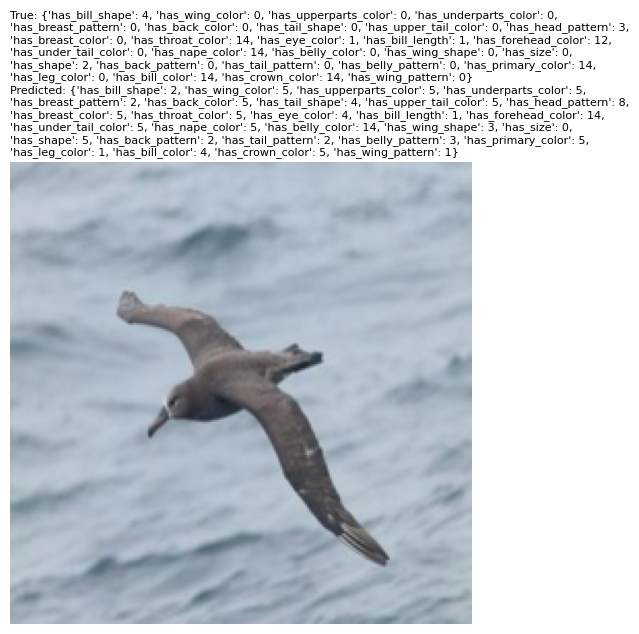

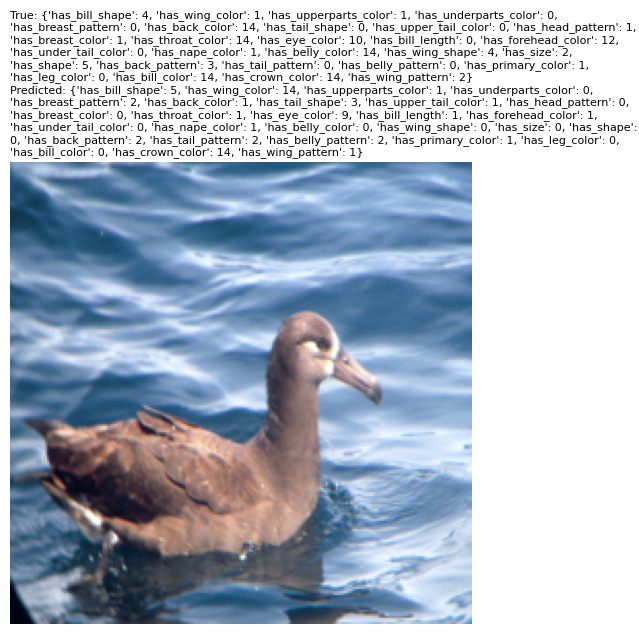

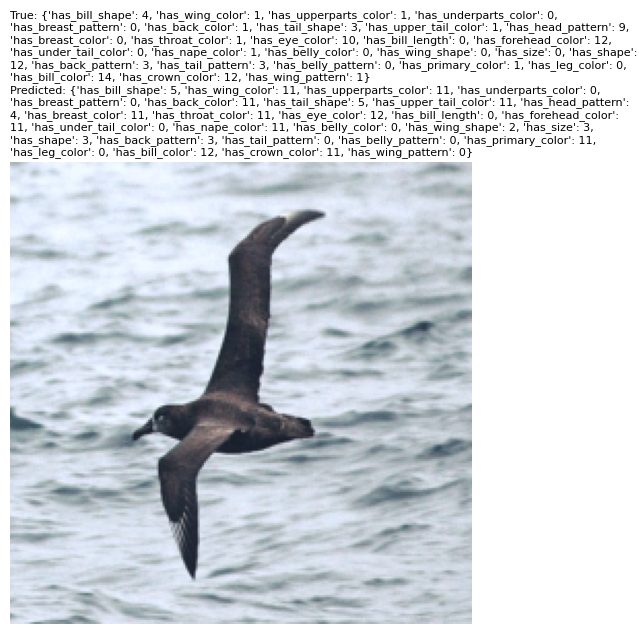

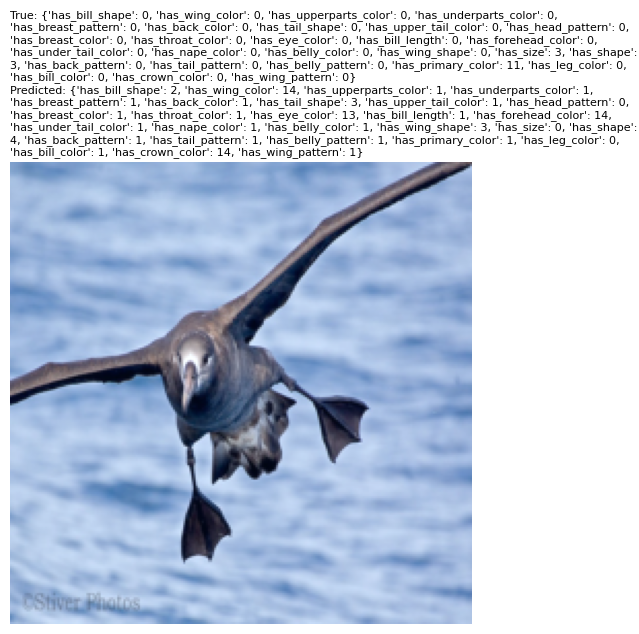

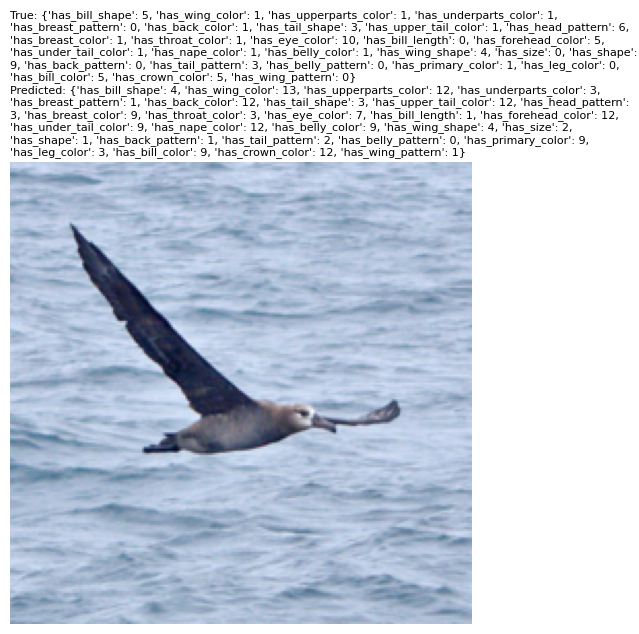

In [18]:
model = ResNetGroupedMultiClass(attribute_groups)
model.load_state_dict(torch.load("../models/grouped_attribute_predictor_weighted.pth"))
visualize_predictions(model, test_loader, attribute_groups, num_examples=5)


In [19]:
def load_attribute_mapping(file_path, attribute_groups):

    attribute_mapping = {group: [] for group in attribute_groups.keys()}
    
    with open(file_path, 'r') as f:
        for line in f:
            index, attribute = line.strip().split(" ", 1)
            index = int(index) - 1  # Nullbasierter Index
            
            attribute_name = attribute.split("::", 1)[-1]
            # Finde, zu welcher Gruppe der Index gehört
            for group, indices in attribute_groups.items():
                if index in indices:
                    attribute_mapping[group].append(attribute_name)
                    break
    
    return attribute_mapping


In [20]:
attribute_mapping = load_attribute_mapping("../data/attributes.txt", attribute_groups)


In [21]:
def visualize_predictions_with_names(model, data_loader, attribute_groups, attribute_mapping, num_examples=5):

    model.eval()
    examples_shown = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = {group: label.to(device) for group, label in labels.items()}
            outputs = model(images)
            
            for i in range(images.size(0)):
                if examples_shown >= num_examples:
                    return
                
                # Bild verarbeiten
                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.229) + 0.485  # Normalisierung rückgängig machen
                image = np.clip(image, 0, 1)

                # True und Predicted Labels
                true_labels = {
                    group: attribute_mapping[group][labels[group][i].item()]
                    for group in attribute_groups.keys()
                }
                predicted_labels = {
                    group: attribute_mapping[group][torch.argmax(outputs[group], dim=1)[i].item()]
                    for group in attribute_groups.keys()
                }

                # Plot
                plt.figure(figsize=(8, 6))
                plt.imshow(image)
                plt.axis('off')
                
                # True und Predicted Labels anzeigen
                plt.title(
                    f"True: {true_labels}\nPredicted: {predicted_labels}",
                    fontsize=8, loc='left', wrap=True
                )
                plt.show()
                
                examples_shown += 1


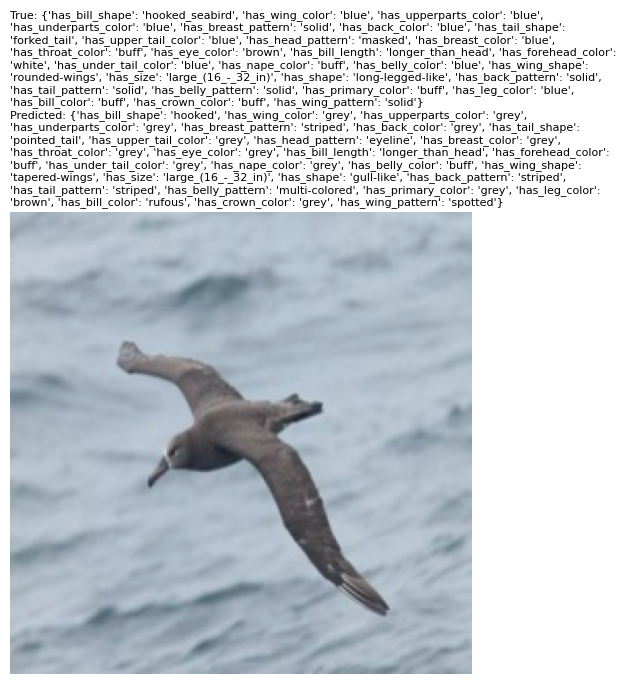

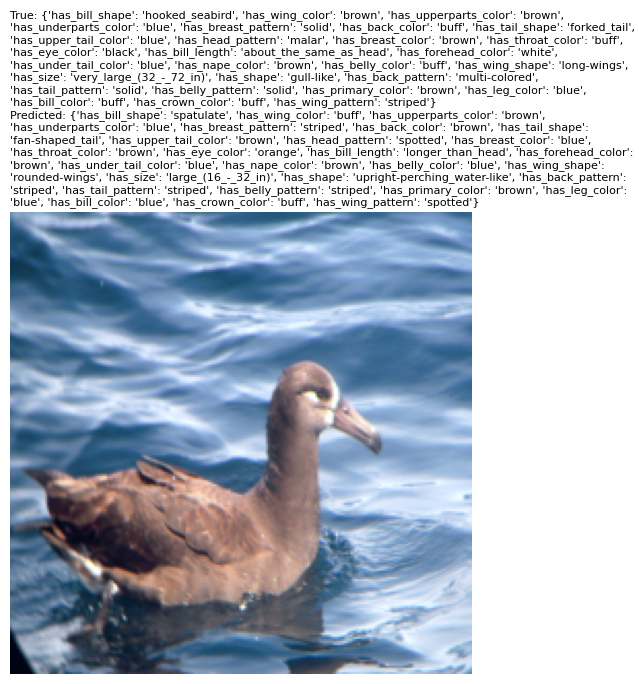

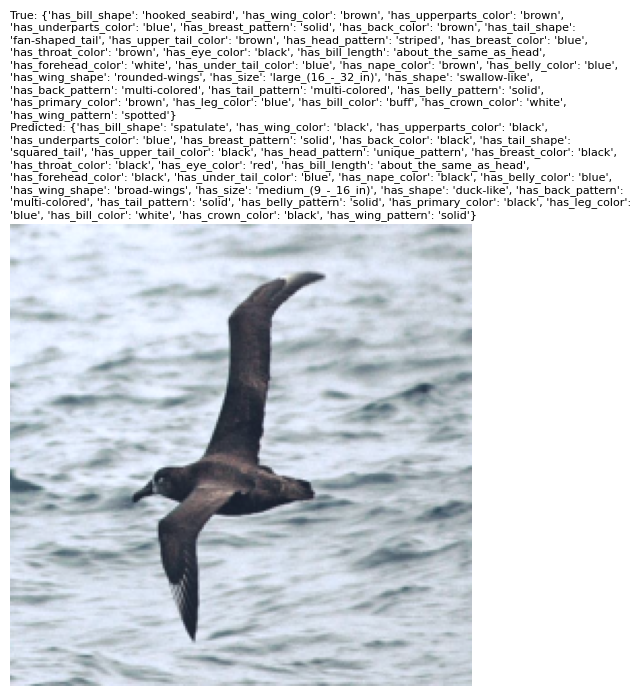

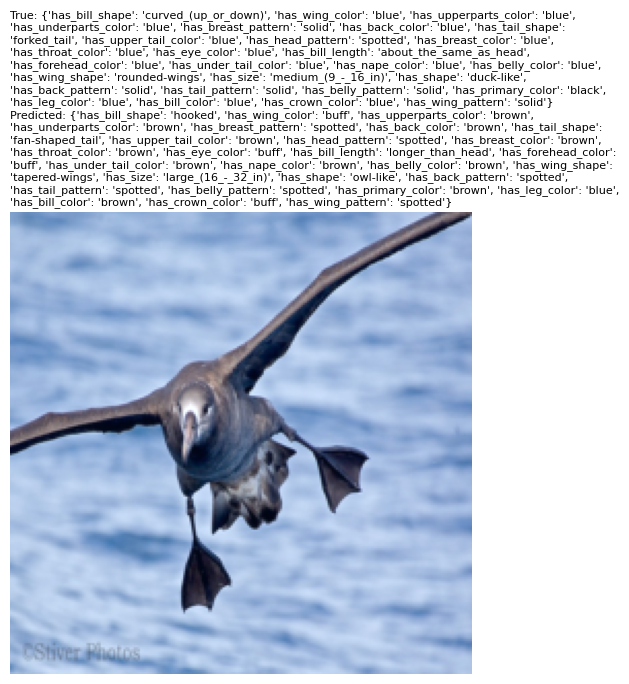

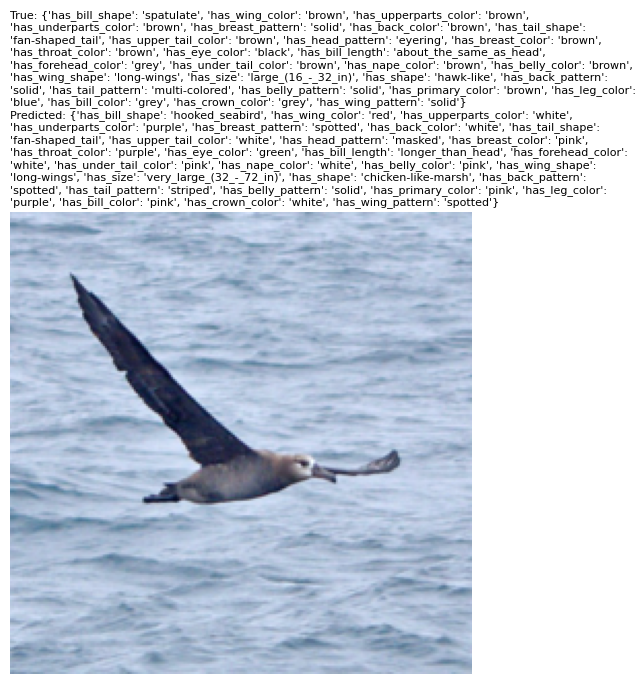

In [22]:
visualize_predictions_with_names(model, test_loader, attribute_groups, attribute_mapping, num_examples=5)

# Hyperparameters
batch_size = 32<br>
epochs = 6<br>
learning_rate = 0.001<br>
image_size = (224, 224)<br>
<br>
data are preprocessed, of per group there are no 1, then first 1 is assigned. if per group is multiple 1 then only first 1 is kept.<br>
Accuracy:<br>
accuracy for group has_bill_shape: 0.41974456334138766<br>
accuracy for group has_wing_color: 0.38280980324473596<br>
accuracy for group has_upperparts_color: 0.3703831549879185<br>
accuracy for group has_underparts_color: 0.3444943044528823
accuracy for group has_breast_pattern: 0.6356575768035899<br>
accuracy for group has_back_color: 0.33983431135657577<br>
accuracy for group has_tail_shape: 0.3369002416292717<br>
accuracy for group has_upper_tail_color: 0.38419054193993785<br>
accuracy for group has_head_pattern: 0.2666551605108733<br>
accuracy for group has_breast_color: 0.33051432516396273<br>
accuracy for group has_throat_color: 0.3610631687953055<br>
accuracy for group has_eye_color: 0.8110113910942354<br>
accuracy for group has_bill_length: 0.6304798066965827<br>
accuracy for group has_forehead_color: 0.3565757680358992<br>
accuracy for group has_under_tail_color: 0.31532619951674146<br>
accuracy for group has_nape_color: 0.32809803244735936<br>
accuracy for group has_belly_color: 0.35381429064549536<br>
accuracy for group has_wing_shape: 0.6216775975146703<br>
accuracy for group has_size: 0.561442871936486<br>
accuracy for group has_shape: 0.5236451501553331<br>
accuracy for group has_back_pattern: 0.5802554366586123<br>
accuracy for group has_tail_pattern: 0.597859855022437<br>
accuracy for group has_belly_pattern: 0.6922678633068692<br>
accuracy for group has_primary_color: 0.3898860890576458<br>
accuracy for group has_leg_color: 0.2889195719710045<br>
accuracy for group has_bill_color: 0.3598550224370038<br>
accuracy for group has_crown_color: 0.35795650673110113<br>
accuracy for group has_wing_pattern: 0.41594753192958234<br>
Total Loss: 7994.3969, Total Accuracy: 0.4413<br>

Klassen verteilung ist auch imbalanced:
{'has_bill_shape': tensor([ 306.,  805.,   93.,  140.,  378.,  245., 2281., 1614.,  132.]),
 'has_wing_color': tensor([ 772., 1602.,   78.,   13.,   49., 1454.,  270.,  127.,   44.,   12.,
           67., 1194.,  137.,   44.,  131.]),
 'has_upperparts_color': tensor([1105., 1457.,  111.,   16.,   51., 1384.,  268.,  120.,   38.,   11.,
           72., 1022.,  164.,   61.,  114.]),
 'has_underparts_color': tensor([ 758.,  613.,   78.,   10.,   72., 1011.,  744.,   76.,   31.,   25.,
          120.,  658., 1302.,  134.,  362.]),
 'has_breast_pattern': tensor([3852.,  370.,  699., 1073.]),
 'has_back_color': tensor([1550., 1207.,   78.,   17.,   38., 1212.,  238.,  120.,   37.,   18.,
           42.,  972.,  213.,   70.,  182.]),
 'has_tail_shape': tensor([1543.,  649., 1792.,  478., 1042.,  490.]),
 'has_upper_tail_color': tensor([2207.,  888.,   50.,   11.,   36.,  966.,  158.,   94.,   30.,   30.,
           49., 1014.,  230.,   72.,  159.]),
 'has_head_pattern': tensor([ 461.,  551.,  216.,  233.,  187.,  622.,  832., 1483.,  542.,  326.,
          541.]),
 'has_breast_color': tensor([ 656.,  697.,   58.,    7.,   75., 1005.,  679.,   63.,   25.,   21.,
          124.,  794., 1256.,  155.,  379.]),
 'has_throat_color': tensor([ 467.,  502.,   70.,   18.,   74.,  884.,  615.,   52.,   26.,   21.,
           85., 1077., 1515.,  174.,  414.]),
 'has_eye_color': tensor([ 362.,  190.,    6.,   66.,  107.,  102.,   11.,   12.,   19.,   88.,
         4796.,   98.,   93.,   44.]),
 'has_bill_length': tensor([2319.,  350., 3325.]),
 'has_forehead_color': tensor([ 608., 1065.,   76.,   27.,   86., 1078.,  401.,   84.,   21.,   18.,
           98., 1485.,  437.,  199.,  311.]),
 'has_under_tail_color': tensor([1756.,  946.,   57.,   10.,   47., 1057.,  216.,   90.,   27.,   18.,
           44., 1194.,  320.,   42.,  170.]),
 'has_nape_color': tensor([ 764., 1040.,   88.,   23.,   75., 1247.,  339.,   96.,   35.,   23.,
           74., 1141.,  596.,  133.,  320.]),
 'has_belly_color': tensor([ 823.,  521.,   65.,    9.,   59.,  932.,  735.,   68.,   35.,   18.,
          121.,  578., 1486.,  136.,  408.]),
 'has_wing_shape': tensor([3788., 1147.,  340.,  427.,  292.]),
 'has_size': tensor([ 216., 3072.,  114., 1167., 1425.]),
 'has_shape': tensor([ 150.,  112.,   67.,  369.,   23.,  420.,  271.,  369.,  412.,  176.,
          283.,  188.,  243., 2911.]),
 'has_back_pattern': tensor([3475.,  387.,  987., 1145.]),
 'has_tail_pattern': tensor([3594.,  274.,  797., 1329.]),
 'has_belly_pattern': tensor([4162.,  341.,  616.,  875.]),
 'has_primary_color': tensor([ 377., 1485.,   75.,   35.,   68., 1459.,  514.,  116.,   42.,   23.,
          110., 1044.,  333.,   95.,  218.]),
 'has_leg_color': tensor([1150.,  475.,   24.,   23.,   55., 1475.,   90.,   10.,    7.,  118.,
          466., 1227.,   90.,  146.,  638.]),
 'has_bill_color': tensor([ 286.,  500.,   57.,   12.,   78., 1552.,  288.,   24.,    8.,   35.,
          351., 2058.,  110.,  144.,  491.]),
 'has_crown_color': tensor([ 626., 1138.,   75.,   20.,   94., 1143.,  338.,   84.,   27.,   19.,
           81., 1483.,  368.,  212.,  286.]),
 'has_wing_pattern': tensor([2357.,  460., 1464., 1713.])}